In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np 
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.optim import lr_scheduler

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [3]:
batch_size = 32

In [4]:
train_transform = transforms.Compose([
        transforms.Resize(256),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
train_dir = '../input/facial-age/face_age/face_age'
files = os.listdir(train_dir)
#files = files.remove('face_age')
print(len(files))


99


In [6]:
d = '../input/facial-age/face_age/face_age/110'
print(d.split('/')[-1])
for i in files:
    if i in d.split('/')[-1]:
        print(int(i))

110
110


In [7]:
classes = []

for i in os.listdir(train_dir):
    classes.append(i)
classes = sorted(classes)
print(len(classes))

99


In [8]:
class AgeDataset(Dataset):
    def __init__(self,directory,file_list,transform = None):
        self.directory = directory
        self.file_list = file_list
        self.transform = transform
        self.k = k
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img =  Image.open(os.path.join(self.directory, self.file_list[idx]))
        img = img.convert('RGB')
        img = self.transform(img)
        
        for i in classes:
            if i == self.directory.split('/')[-1]:
                self.label = int(i)
                
            else:
                continue
                
        img = img.numpy()
        return img.astype('float32'), self.label

In [9]:
'''
k=0
working_ds = None
for c in classes:
    directory = os.path.join(train_dir,c)
    file_list = os.listdir(directory)
    if c in directory.split('/')[-1]:
        print(c)
        k=k+1
    new = AgeDataset(directory,file_list,train_transform)
    
    if working_ds == None:
        working_ds = new
    else:
        working_ds = ConcatDataset([working_ds,new])
print(len(working_ds))
print(k)'''


"\nk=0\nworking_ds = None\nfor c in classes:\n    directory = os.path.join(train_dir,c)\n    file_list = os.listdir(directory)\n    if c in directory.split('/')[-1]:\n        print(c)\n        k=k+1\n    new = AgeDataset(directory,file_list,train_transform)\n    \n    if working_ds == None:\n        working_ds = new\n    else:\n        working_ds = ConcatDataset([working_ds,new])\nprint(len(working_ds))\nprint(k)"

In [10]:
working_ds = datasets.ImageFolder(root = os.path.join(train_dir),transform = train_transform)
print(len(working_ds))
train_ds,val_ds = random_split(working_ds,[9000,778])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=32, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_ds,
                                          batch_size=32, 
                                          shuffle=False)

9778


In [11]:
def train_val_split(working_ds):
    val_split = 0.05
    l = float(len(working_ds))
    m = int(val_split*l)
    train_ds,val_ds = random_split(working_ds,[int(l)-m,m])
    return train_ds,val_ds

In [12]:
#train_ds,val_ds = train_val_split(working_ds)

In [13]:
i,l = next(iter(train_loader))
print(l.shape)

torch.Size([32])


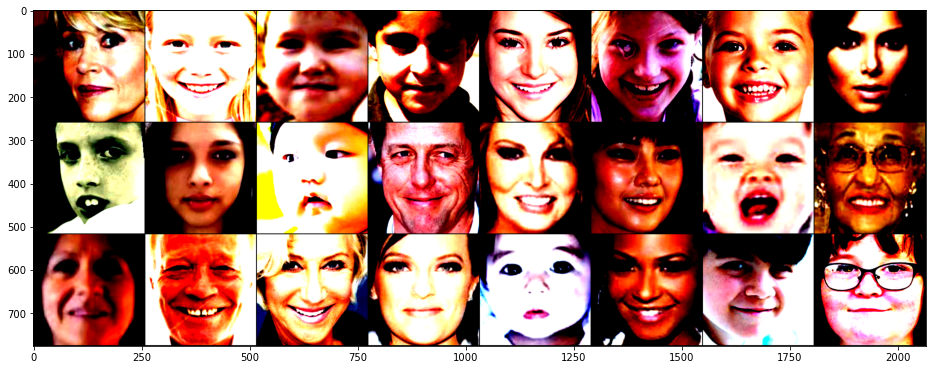

In [14]:
import matplotlib.pyplot as plt
import numpy
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [15]:
def model_eval(dataloader,model):
    total = 0
    correct = 0
    for data in dataloader:
      images, l = data
      
      images = images.to(device)
      l = l.to(device)
      
      out = model(images).float()
      
      
      total += l.shape[0]                   
      correct += (preds == l).sum().item()  
      accuracy = (100 * correct)/total
    
    
    return accuracy

In [16]:


def train(model, criterion, optimizer,sch,num_epochs):
  for epoch in range(num_epochs): 
      print("Epoch:",epoch+1)
      running_loss = 0.0
      
      for i,data in enumerate(train_loader,0):
          inputs,labels = data
          
          
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          optimizer.zero_grad()
    
          output = model(inputs)
          output = output.to(device)
          loss = criterion(output, labels)
    
          loss.backward()
          optimizer.step()
          
          
          running_loss += loss.item()
    
    
          if i % 50 == 49:    
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 50))
              running_loss = 0.0
      sch.step()  
      print('Epoch:', epoch+1,'LR:', sch.get_last_lr())
      print("EPOCH OVER")
      train_acc = model_eval(train_loader,model)
      with torch.no_grad():
        test_acc = model_eval(val_loader,model)
      print("############################")
      print("Training Accuracy:",train_acc,"Testing Accuracy",test_acc)
      print("############################")
      print("")
  return model
    


In [17]:
vgg16_backbone = models.vgg16(pretrained=True)

for param in vgg16_backbone.parameters():
      param.requires_grad = False
#num_ftrs = vgg16_backbone.fc.in_features
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(*list(vgg16_backbone.features.children()))

        self.drop1 = nn.Dropout(0.3)
        #self.drop2 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(32768,1024)
        #self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(1024,1)
        self.final = nn.Sigmoid()
    def forward(self,x):
    
        x = self.features(x)

        x = x.view(x.shape[0],32768)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        #x = F.relu(self.fc2(x))
       
        #x = self.drop2(x)
        x = self.fc3(x)
        #x = self.drop1(x)
        #x = F.relu(self.fc4(x))
        x = self.final(x)

        return x       


criterion = nn.CrossEntropyLoss()  
    
vgg_model = VGG16()
vgg_model = vgg_model.to(device)



#optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
print(vgg_model)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [18]:
from tqdm import tqdm
def train(loader, model, optimizer, criterion, scaler):
    loop = tqdm(loader) #For the progress bar
    
    for idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.type(torch.float32).unsqueeze(1).to(device)
        targets = 0.01 + targets/100
        #forward pass
        with torch.cuda.amp.autocast():
            pred = model(data)
            loss = criterion(pred, targets)
        #backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #scheduler.step()
        #lr.append(get_lr(optimizer))
        loop.set_postfix(loss = loss.item())

In [19]:
from tqdm import tqdm
def train1( loader, model, optimizer, criterion, scaler):
        loop = tqdm(loader) #For the progress bar
    
    #for idx, (data, targets) in enumerate(loop):
        data, targets = next(iter(train_loader))
        data = data.to(device)
        targets = targets.float().to(device)
        
        
        #forward pass
        with torch.cuda.amp.autocast():
            pred = model(data)
            loss = criterion(pred, targets)
        #backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss = loss.item())

In [20]:
d,l = next(iter(train_loader))
d = d.to(device)
l = l.to(device)
x = vgg_model(d).unsqueeze(1)
print(x.shape)
print(l.shape)

torch.Size([32, 1, 1])
torch.Size([32])


In [21]:
optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

scaler = torch.cuda.amp.GradScaler()
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    print(f"epoch:{epoch}/{NUM_EPOCHS}")
    train(train_loader, vgg_model, optimizer, criterion, scaler)

  0%|          | 0/282 [00:00<?, ?it/s]

epoch:0/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:1/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:2/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:3/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:4/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:5/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:6/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:7/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:8/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:9/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:10/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:11/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:12/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:13/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:14/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:15/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:16/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:17/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:18/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:19/20


100%|██████████| 282/282 [01:12<00:00,  3.92it/s, loss=0.00125] 


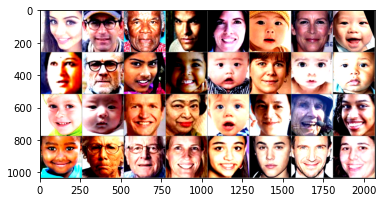

[20, 46, 56, 25, 39, 1, 65, 1, 52, 67, 15, 3, 1, 32, 1, 1, 4, 1, 39, 60, 1, 32, 90, 17, 5, 85, 67, 35, 16, 22, 51, 29]
[21, 47, 56, 27, 39, 0, 59, 1, 60, 68, 7, 5, 0, 27, 0, 0, 2, 0, 39, 61, 0, 40, 96, 19, 3, 90, 68, 34, 15, 24, 49, 28]


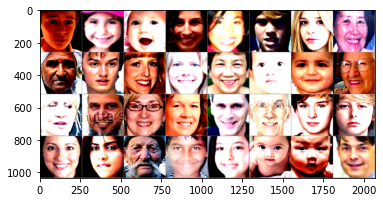

[14, 5, 1, 33, 27, 15, 17, 70, 56, 24, 20, 27, 65, 2, 1, 85, 56, 48, 29, 38, 42, 78, 16, 13, 29, 22, 90, 14, 13, 1, 1, 46]
[10, 5, 0, 37, 20, 16, 20, 60, 59, 24, 20, 22, 64, 2, 0, 85, 53, 52, 33, 36, 46, 81, 11, 9, 30, 18, 87, 17, 17, 0, 0, 38]


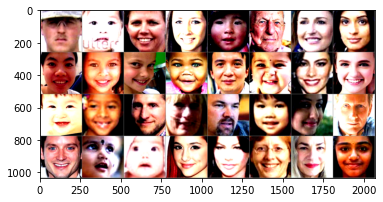

[29, 2, 35, 18, 21, 90, 33, 26, 30, 5, 9, 2, 39, 4, 26, 12, 1, 8, 30, 56, 45, 4, 26, 39, 33, 2, 1, 18, 24, 49, 70, 15]
[29, 0, 37, 13, 22, 88, 29, 27, 26, 7, 15, 0, 43, 2, 28, 8, 0, 8, 33, 57, 38, 2, 26, 46, 30, 2, 0, 12, 23, 50, 64, 15]


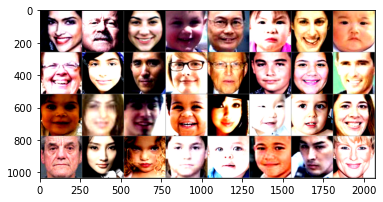

[29, 65, 19, 4, 57, 4, 29, 1, 56, 15, 42, 32, 63, 17, 18, 35, 4, 26, 22, 2, 24, 1, 4, 38, 73, 26, 3, 8, 1, 9, 29, 52]
[31, 64, 21, 4, 56, 0, 30, 0, 61, 15, 39, 33, 64, 17, 20, 32, 3, 25, 18, 3, 17, 1, 4, 37, 71, 26, 4, 11, 0, 10, 31, 43]


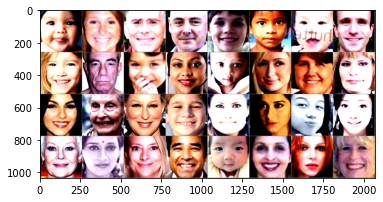

[2, 26, 51, 39, 9, 4, 1, 32, 8, 70, 4, 27, 1, 26, 48, 51, 25, 86, 72, 9, 26, 32, 14, 27, 80, 20, 29, 42, 1, 32, 24, 52]
[0, 29, 51, 25, 8, 2, 0, 29, 4, 69, 5, 25, 2, 33, 49, 42, 28, 88, 67, 4, 30, 34, 9, 27, 82, 16, 28, 45, 0, 41, 33, 58]


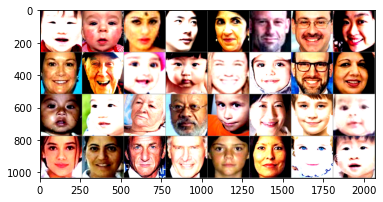

[2, 1, 29, 25, 58, 35, 48, 30, 49, 90, 1, 1, 22, 4, 42, 56, 3, 2, 85, 58, 5, 42, 9, 1, 18, 42, 52, 72, 14, 36, 3, 3]
[0, 0, 37, 22, 51, 32, 48, 29, 45, 85, 0, 0, 20, 3, 44, 50, 0, 0, 88, 58, 2, 37, 8, 1, 21, 40, 47, 74, 15, 32, 1, 0]


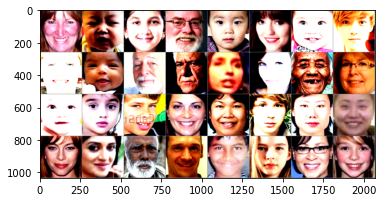

[56, 2, 8, 58, 4, 20, 2, 18, 9, 1, 75, 66, 27, 20, 90, 48, 1, 4, 9, 26, 49, 16, 32, 36, 29, 26, 85, 39, 14, 14, 36, 12]
[56, 6, 7, 60, 0, 21, 0, 15, 7, 0, 73, 72, 29, 16, 90, 46, 0, 2, 8, 27, 46, 16, 41, 35, 30, 19, 85, 36, 9, 15, 39, 10]


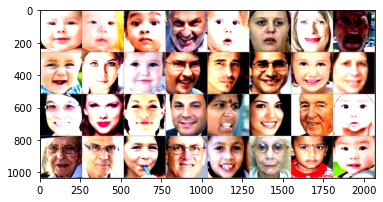

[1, 1, 2, 60, 3, 27, 56, 65, 1, 18, 2, 30, 26, 36, 4, 39, 57, 25, 33, 30, 36, 24, 78, 1, 85, 65, 9, 53, 9, 85, 2, 2]
[0, 2, 0, 64, 0, 30, 57, 65, 2, 23, 0, 31, 25, 42, 3, 38, 55, 24, 36, 40, 43, 17, 79, 0, 85, 66, 4, 54, 5, 81, 2, 0]


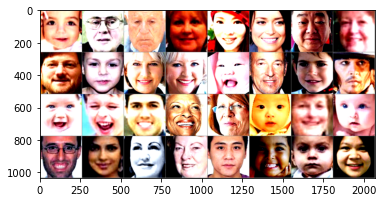

[1, 77, 85, 45, 29, 25, 56, 49, 39, 8, 48, 58, 1, 65, 4, 49, 1, 4, 26, 85, 70, 1, 53, 1, 33, 27, 48, 58, 27, 3, 7, 19]
[1, 80, 87, 46, 30, 18, 57, 51, 40, 6, 45, 54, 0, 60, 4, 65, 0, 2, 24, 82, 71, 0, 55, 0, 37, 27, 48, 55, 30, 4, 6, 19]


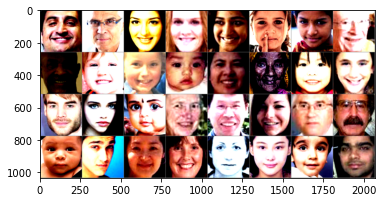

[35, 65, 22, 26, 16, 9, 15, 86, 62, 4, 9, 2, 27, 89, 3, 8, 24, 15, 1, 51, 49, 26, 58, 56, 1, 16, 29, 33, 36, 23, 4, 26]
[36, 63, 24, 25, 20, 13, 16, 86, 53, 0, 14, 0, 28, 93, 0, 13, 23, 14, 1, 60, 47, 28, 62, 59, 0, 14, 29, 32, 38, 28, 5, 28]


In [22]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
for i in range(10):
    dataiter = iter(train_loader)
    x, y = dataiter.next()
    x=x.cuda()
    y=.01+y.reshape((32,1)).cuda().type(torch.float32)/100
    z=vgg_model(x)

    imshow(torchvision.utils.make_grid(x.cpu()))
    y=(y*100).type(torch.int64)
    z=(z*100).type(torch.int64)
    print(y.reshape(1,32).tolist()[0])
    print(z.reshape(1,32).tolist()[0])
    